### A Simplied Interface to Text Classification With Hugging Face Transformers in TensorFlow Using [ktrain](https://github.com/amaiya/ktrain)

*ktrain* requires TensorFlow 2.

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.7.0


We then need to install *ktrain* library using pip.

In [ ]:
!pip3 install -q ktrain

### Load a Dataset Into Arrays

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
import numpy as np


def clean_reviews(review):
    clean_review = BeautifulSoup(review, features='lxml')
    clean_review = clean_review.get_text().replace('"', "")
    clean_review = clean_review.replace('\n', ' ').replace('\r', '').replace('\t', '')
    clean_review = clean_review.replace('\s{2,}', ' ')
    return clean_review


def load_data(file_path, year_range=[2008, 2017], usefulCount_range=[0, 10000], usefulCount_quantile=None,
              quantiles_for_class=[0.25, 0.5, 0.75], singleCondition=None):
    # Read CSV
    df = pd.read_csv(file_path, encoding='utf-8')

    # Remove duplicate reviews
    df = df.drop_duplicates(subset=['review', 'condition', 'date', 'rating', 'usefulCount'])

    # Get most common conditions (by review count)
    top_conditions = list(df.groupby('condition').count().reset_index().sort_values(by='uniqueID', ascending=False)[:10]['condition'])
    df = df.loc[df['condition'].isin(top_conditions)]

    # Get single condition (if passed in)
    if singleCondition is not None:
        df = df.loc[df['condition']==singleCondition]

    # Filter the reviews by the input year_range
    df['date'] = pd.to_datetime(df['date'])
    df = df.loc[(df.date.dt.year >= year_range[0]) & (df.date.dt.year <= year_range[1]), :]

    # Create onehot encoding for the condition so we can use it as a feature as well
    df = pd.concat([df, pd.get_dummies(df['condition'])], axis=1)

    # Clean review text
    df['cleanReview'] = df['review'].apply(clean_reviews)

    # Create standardized usefulScoreLog column (log of usefulCount normalized to be between 0 and 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        df['usefulScoreLog'] = np.log(df['usefulCount']) / np.max(np.log(df['usefulCount']))
    df['usefulScoreLog'] = df['usefulScoreLog'].replace(-np.Inf, 0)

    # Cap the usefulCount to create a new target variable column
    if usefulCount_quantile is not None:
        usefulCount_range = [0, int(df['usefulCount'].quantile(q=usefulCount_quantile))]
    df['usefulCountCapped'] = df['usefulCount'].apply(lambda row : cap_col_val(row, usefulCount_range))

    # Normalize usefulCountCapped
    df['usefulCountCappedNormalized'] = df['usefulCountCapped'] / max(df['usefulCountCapped'])

    # Create normalized rating (0 to 1) to be used as a metadata feature
    df['ratingNormalized'] = df['rating'] / np.max(df['rating'])

    # Cast the date column to be a date datatype and compute the review age (with 0 corresponding to the most recent review)
    df['daysOld'] = (max(df['date']) - df['date']).astype('timedelta64[s]') / (60*60*24)

    # Compute an age score as daysOld normalized to be between 0 and 1
    with np.errstate(divide='ignore', invalid='ignore'):
        df['ageScore'] = df['daysOld'] / np.max(df['daysOld'])
    df['ageScore'] = df['ageScore'].replace(-np.Inf, 0)

    # Create a usefulCountClass column to treat usefulness prediction as a classification problem
    if quantiles_for_class is not None:
        buckets = get_buckets(df=df, quantiles=quantiles_for_class)
        df['usefulCountClass'] = df['usefulCount'].apply(lambda row : assign_bucket(row, buckets))

    # Split data into train and val
    train = df.sample(frac=0.75, random_state=8)
    val = df.loc[~df['uniqueID'].isin(train['uniqueID'])]

    return train, val



def cap_col_val(val, usefulCount_range):
    if val > usefulCount_range[-1]:
        val = usefulCount_range[-1]
    return val


def assign_bucket(val, buckets):
    for i, bucket in enumerate(buckets):
        if val <= 0:
            new_val = 0  # assigns the 0 label to predictions below 0
        if bucket[0] <= val < bucket[1]:
            new_val = i
    return new_val


def get_buckets(df, quantiles):
    cutoffs = []
    buckets = []
    for i in quantiles:
        cutoffs.append(df['usefulCount'].quantile(q=i))
    for i in range(1, len(cutoffs)):
        if i == 1:
            buckets.append([0, cutoffs[i-1]])
        buckets.append([cutoffs[i-1], cutoffs[i]])
        if i == len(cutoffs) - 1:
            buckets.append([cutoffs[i], np.inf])
    if len(cutoffs)==1:
        buckets.append([0, cutoffs[0]])
        buckets.append([cutoffs[0], np.inf])
    return buckets

In [ ]:
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer

num_vals = 2
curr_quantiles = np.array([(1/num_vals)*i for i in range(1, num_vals)])


train, val = load_data('drugsComTrain_raw.csv', year_range=[2013, 2017], quantiles_for_class=curr_quantiles)
train = shuffle(train)
val = shuffle(val)
#train = shuffle(pd.concat((train, val), axis=0))
x_train = train['cleanReview'].values
y_train = train['usefulCountClass'].values

tr, va = load_data('drugsComTest_raw.csv', year_range=[2013, 2017], quantiles_for_class=curr_quantiles)
test = shuffle(pd.concat((tr, va), axis=0))
x_test = val['cleanReview'].values
y_test = val['usefulCountClass'].values

print(y_train.shape)
print(y_test.shape)

(27036,)
(9012,)


## STEP 1:  Preprocess Data and Create a Transformer Model

We will use [DistilBERT](https://arxiv.org/abs/1910.01108).

In [ ]:
y_train.shape

(27036,)

In [ ]:
import ktrain
from ktrain import text
MODEL_NAME = 'distilbert-base-uncased'
t = text.Transformer(MODEL_NAME, maxlen=500, class_names=np.array([0, 1]))
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=8)

preprocessing train...
language: en
train sequence lengths:
	mean : 95
	95percentile : 148
	99percentile : 156


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 96
	95percentile : 147
	99percentile : 156


## STEP 2:  Train the Model

simulating training for different learning rates... this may take a few moments...
Epoch 1/2
3379/3379 [==============================] - 961s 280ms/step - loss: 0.6125 - accuracy: 0.6550
Epoch 2/2
3379/3379 [==============================] - 875s 259ms/step - loss: 139.2226 - accuracy: 0.4973


done.
Visually inspect loss plot and select learning rate associated with falling loss


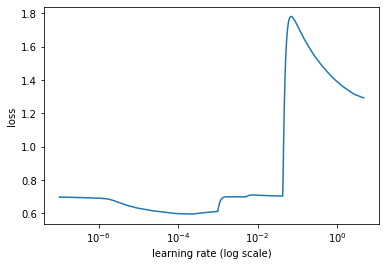

In [ ]:
learner.lr_find(show_plot=True, max_epochs=2)

In [ ]:
learner.fit_onecycle(5e-5, 2)



begin training using onecycle policy with max lr of 5e-05...
Epoch 1/2
3380/3380 [==============================] - 1053s 308ms/step - loss: 0.5189 - accuracy: 0.7615 - val_loss: 0.4918 - val_accuracy: 0.7769
Epoch 2/2
3380/3380 [==============================] - 1045s 308ms/step - loss: 0.4554 - accuracy: 0.7972 - val_loss: 0.4644 - val_accuracy: 0.7874


## STEP 3: Evaluate and Inspect the Model

In [ ]:
learner.validate(class_names=t.get_classes())

              precision    recall  f1-score   support

           0       0.80      0.76      0.78      4462
           1       0.78      0.81      0.79      4550

    accuracy                           0.79      9012
   macro avg       0.79      0.79      0.79      9012
weighted avg       0.79      0.79      0.79      9012



array([[3403, 1059],
       [ 857, 3693]])

Let's examine the validation example about which we were the most wrong.

In [ ]:
learner.view_top_losses(n=1, preproc=t)

----------
id:4426 | loss:3.96 | true:1 | pred:0)



In [ ]:
print(x_test[7225])

I've been on Latuda for around 8 months now.  I have a Dr appointment next week and I am going to ask to switch to something else or add another med to it.  I am tired all the time.  I can barely stay awake within an hour of taking it.  I am emotionless.  Never feel better than a 5 out of 10.  Don't feel happiness.  No joy in any activities.  It's definitely good at evening you out....too good.  It has not conquered my depression.  I find it hard to focus and it is starting to effect my job.  I just want to feel happy again.


## STEP 4: Making Predictions on New Data in Deployment

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

In [ ]:
predictor.predict("I was suffering from being a slave to my negative thoughts, making assumptions about my relationship that my partner was cheating on me or having a secret life, constantly being controlling over where things go in the house, how things should be, really severe mood swings and ridiculous anger which I would ignite a lot of arguments and have the urge to get physical and just completely lose it and not think rationally. My marriage was on the verge of failure due to my negative actions and my husband was at his breaking point. My doc prescribed me 50mg of Zoloft and I finally started it, I\'m on week 2 and I feel incredibly calm, content and full of life again. I feel like I can handle situation in a positive manner.")

1

In [ ]:
# predicted probability scores for each category
predictor.predict_proba("I was suffering from being a slave to my negative thoughts, making assumptions about my relationship that my partner was cheating on me or having a secret life, constantly being controlling over where things go in the house, how things should be, really severe mood swings and ridiculous anger which I would ignite a lot of arguments and have the urge to get physical and just completely lose it and not think rationally. My marriage was on the verge of failure due to my negative actions and my husband was at his breaking point. My doc prescribed me 50mg of Zoloft and I finally started it, I\'m on week 2 and I feel incredibly calm, content and full of life again. I feel like I can handle situation in a positive manner.")

array([0.03686758, 0.96313244], dtype=float32)

In [ ]:
predictor.get_classes()

[0, 1]

As expected, `Birth Control` is assigned the highest probability.

Let's invoke the `explain` method to see which words contribute most to the classification.

We will need a forked version of the **eli5** library that supportes TensorFlow Keras, so let's install it first.

In [ ]:
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1


In [ ]:
predictor.explain("I was suffering from being a slave to my negative thoughts, making assumptions about my relationship that my partner was cheating on me or having a secret life, constantly being controlling over where things go in the house, how things should be, really severe mood swings and ridiculous anger which I would ignite a lot of arguments and have the urge to get physical and just completely lose it and not think rationally. My marriage was on the verge of failure due to my negative actions and my husband was at his breaking point. My doc prescribed me 50mg of Zoloft and I finally started it, I\'m on week 2 and I feel incredibly calm, content and full of life again. I feel like I can handle situation in a positive manner.")

In [ ]:
predictor.explain("This medication was okay.")

In [ ]:
predictor.explain("This medication was bad.")

In [ ]:
predictor.explain("This medication was great.")

In [ ]:
#Review for belviq medication from 8-oct-14 with rating of 1 and usefulscore of 109

predictor.explain("I took one tablet in the morning and I was fine until the afternoon. In the afternoon I had a debilitating headache and could not function. The pain spread to the back of my neck. I could hardly move. Then to top it all off, I started feeling nauseous. I lied down on the couch and stay still but I still threw up.")

In [ ]:
# Note: this review is 12-apr-17, drug is Adipex, for Weightloss. Rating is 10. It is useful

predictor.explain("I took Adipex for 1 year and lost 90lbs. I changed my eating habits and starting doing light exercise 3 days a week. I've been off Adipex for 3 months and haven't gained any weight back. Just stick with a healthy eating plan and you will not gain. Medications should be used as a tool if you don't change your eating habits then you can gain all the weight back. *sidenote...please stop writing reviews when you haven't taken the medication or just started the medication. The purpose of a review is to give your opinion on a product after using it for some time. Announcing that your doctor has prescribed Adipex isn't a review and it isn't helpful for people who are looking for reviews on this website..rant over.")

In [ ]:
predictor.explain("Workedad wonders!")

In [ ]:
predictor.explain("Ready to try it out!")

In [ ]:
predictor.explain("My husband is now taking this. The first week was not so bad, he even mentioned he felt somewhat better.  This is week 2, 20's.  And he still complains of his symptoms, he is extremely moody and sleeps ALL OF THE TIME!!!  And he still has more increases to do in the packet.  Can't wait for that. I want my husband back.  Needless to say I  do not recommend this drug.")

In [ ]:
predictor.save('drugUsefulClassifier')

In [ ]:
!zip -r saved_keras_model.zip my_distilbert_predictor

  adding: my_distilbert_predictor/ (stored 0%)
  adding: my_distilbert_predictor/config.json (deflated 55%)
  adding: my_distilbert_predictor/tokenizer_config.json (deflated 40%)
  adding: my_distilbert_predictor/vocab.txt (deflated 53%)
  adding: my_distilbert_predictor/tokenizer.json (deflated 59%)
  adding: my_distilbert_predictor/tf_model.preproc (deflated 46%)
  adding: my_distilbert_predictor/tf_model.h5 (deflated 8%)
  adding: my_distilbert_predictor/special_tokens_map.json (deflated 40%)


In [ ]:
from google.colab import files
files.download("saved_keras_model.zip")


In [ ]:
loaded_model = ktrain.load_predictor('/tmp/drugUsefulClassifier')

In [ ]:
loaded_model.predict('I am not sure about this medication. It is both good and bad.')

'comp.graphics'